Copyright (c) 2020 Ryan Cohn and Elizabeth Holm. All rights reserved. <br />
Licensed under the MIT License (see LICENSE for details) <br />
Written by Ryan Cohn

# Instance Segmentation of Powder Particles and Satellites

This example will take you through the process of training a model to segment powder particles and visualizing the model predictions.

In [1]:
## regular module imports
import cv2
import json
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import pickle
import skimage.io
import sys

## detectron2
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import (
    DatasetCatalog,
    MetadataCatalog,
)
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.structures import BoxMode

root = '../../../'
ocean_images = root + '../../../../ocean/projects/dmr200021p/sprice/initial_paper_complete_set/'
ocean_syn = root + '../../../../ocean/projects/dmr200021p/sprice/synthetic_training/'
sys.path.append(root)

from ampis import data_utils, visualize, export_anno

%matplotlib inline

# Labeling Data

The [VGG Image Annotator](http://www.robots.ox.ac.uk/~vgg/software/via/) was used to generate particle labels. The a

# Loading Data
The process for training models for powder particles and satellites is identical. Enter the corresponding value depending on which model you want to train. <br />
The paths to individual images, and all annotation data are stored in the JSON files generated by the VGG image annotator.



In [7]:
EXPERIMENT_NAME = 'satellite' # can be 'particle' or 'satellite'
json_path_train = Path(ocean_syn,'trainings','synthetic_training_satellite_a1.0.json')  # path to training data
json_path_val = Path(ocean_syn,'trainings', 'synthetic_validation_satellite_a1.0.json')  # path to training data
assert json_path_train.is_file(), 'training file not found!'
assert json_path_val.is_file(), 'validation file not found!'


## Registration
Detectron2 requires that datasets be registered for later use.
Registration stores the name of the dataset and a function that can be used to retrieve the image paths and labels in a format that the model can use.

In [8]:
DatasetCatalog.clear()  # resets catalog, helps prevent errors from running cells multiple times

# store names of datasets that will be registered for easier access later
dataset_train = f'{EXPERIMENT_NAME}_Train'
dataset_valid = f'{EXPERIMENT_NAME}_Val'

# register the training dataset
DatasetCatalog.register(dataset_train, lambda f = json_path_train: data_utils.get_ddicts(label_fmt='via2',  # annotations generated from vgg image annotator
                                                                                                     im_root=f,  # path to the training data json file
                                                                                                     dataset_class='Train'))  # indicates this is training data
# register the validation dataset
DatasetCatalog.register(dataset_valid, lambda f = json_path_val: data_utils.get_ddicts(label_fmt='via2',  # annotations generated from vgg image annotator
                                                                                                im_root=f,  # path to validation data json file
                                                                                                dataset_class='Validation'))  # indicates this is validation data
                              
print(f'Registered Datasets: {DatasetCatalog.list()}')

## There is also a metadata catalog, which stores the class names.
for d in [dataset_train, dataset_valid]:
    MetadataCatalog.get(d).set(**{'thing_classes': [EXPERIMENT_NAME]})

Registered Datasets: ['satellite_Train', 'satellite_Val']


## Verify images and annotations are loaded correctly
Also, this is a great time to admire my hand-drawn labels, which took sooooo long to do!
### Training Data

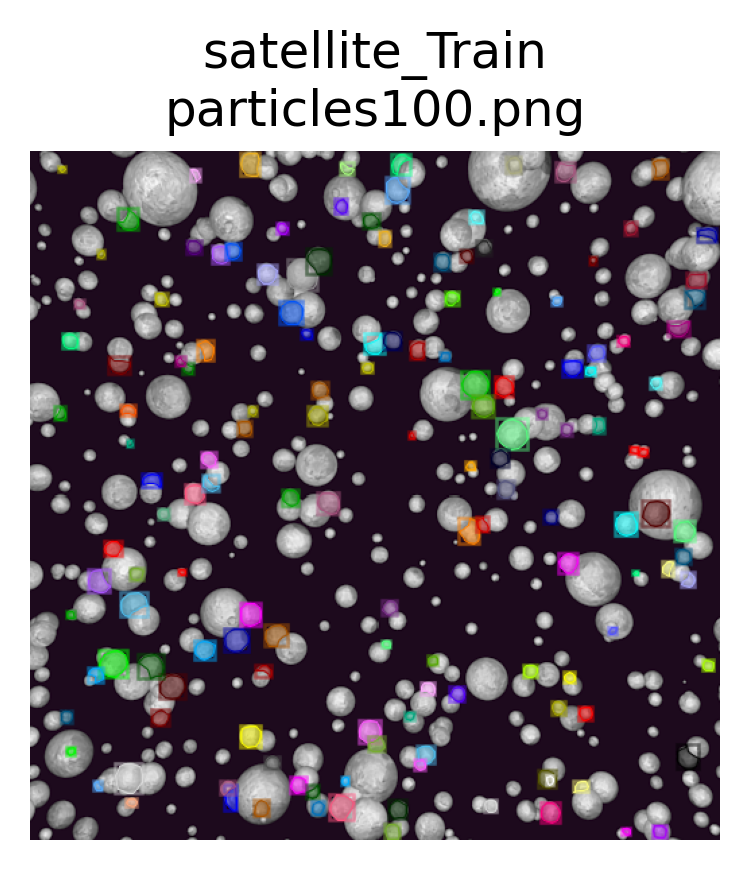

ddict info:
	path: ../../../../../../../ocean/projects/dmr200021p/sprice/synthetic_training/trainings/../images/a-lognormal-loc0.1-shape0.5/renders/particles100.png
	num_instances: 148


In [10]:
#for i in np.random.choice(DatasetCatalog.get(dataset_train), 3, replace=False):
    #visualize.display_ddicts(i, None, dataset_train, suppress_labels=True)
for i in DatasetCatalog.get(dataset_train):
    visualize.display_ddicts(i, None, dataset_train, suppress_labels=True)

### Validation Data

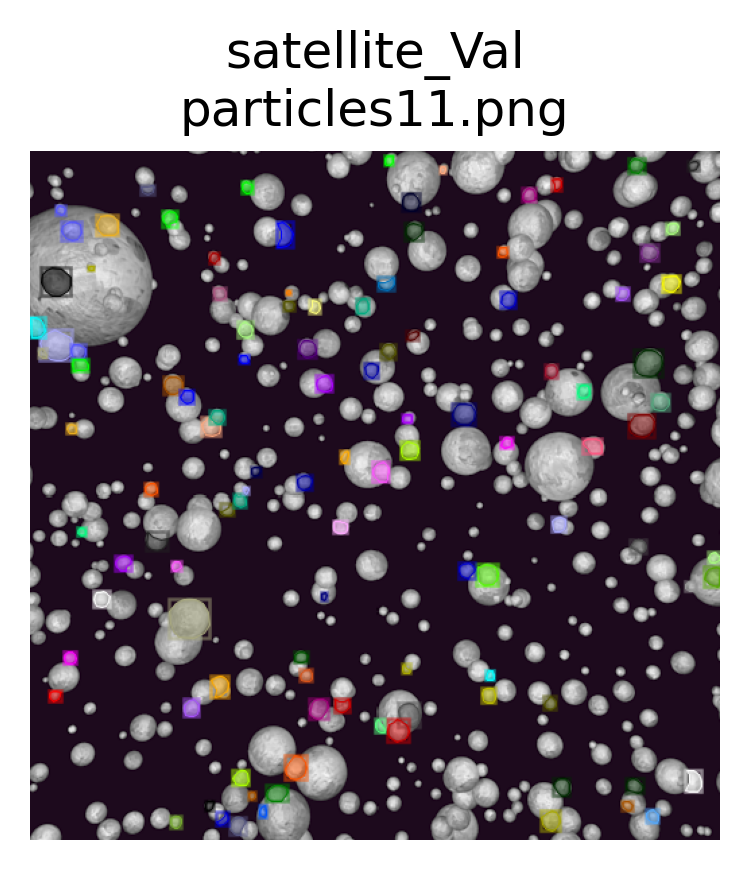

ddict info:
	path: ../../../../../../../ocean/projects/dmr200021p/sprice/synthetic_training/trainings/../images/a-lognormal-loc0.1-shape0.5/renders/particles11.png
	num_instances: 110


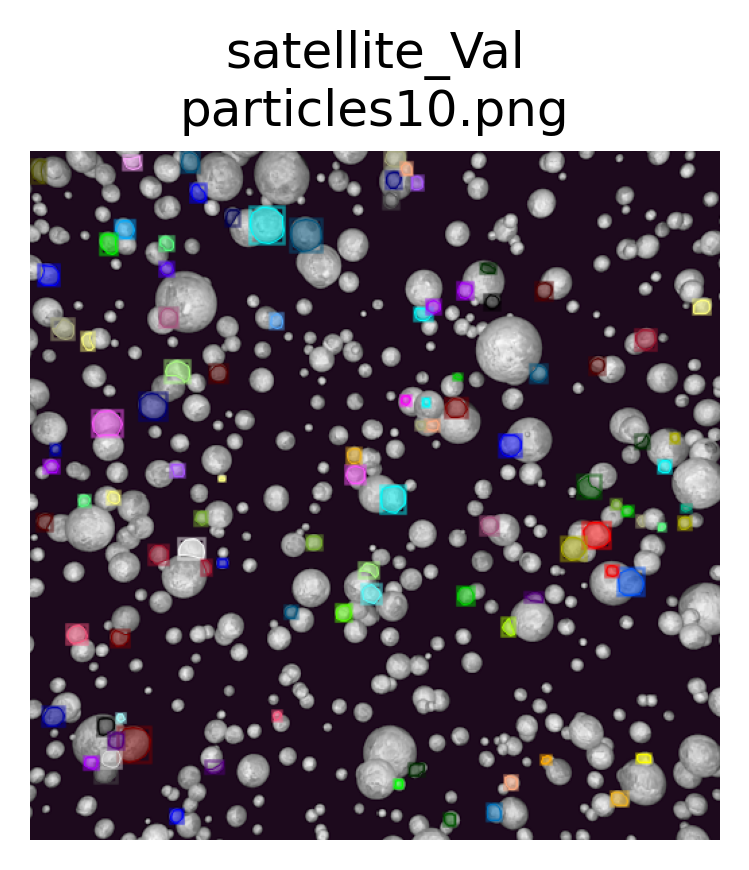

ddict info:
	path: ../../../../../../../ocean/projects/dmr200021p/sprice/synthetic_training/trainings/../images/a-lognormal-loc0.1-shape0.5/renders/particles10.png
	num_instances: 101


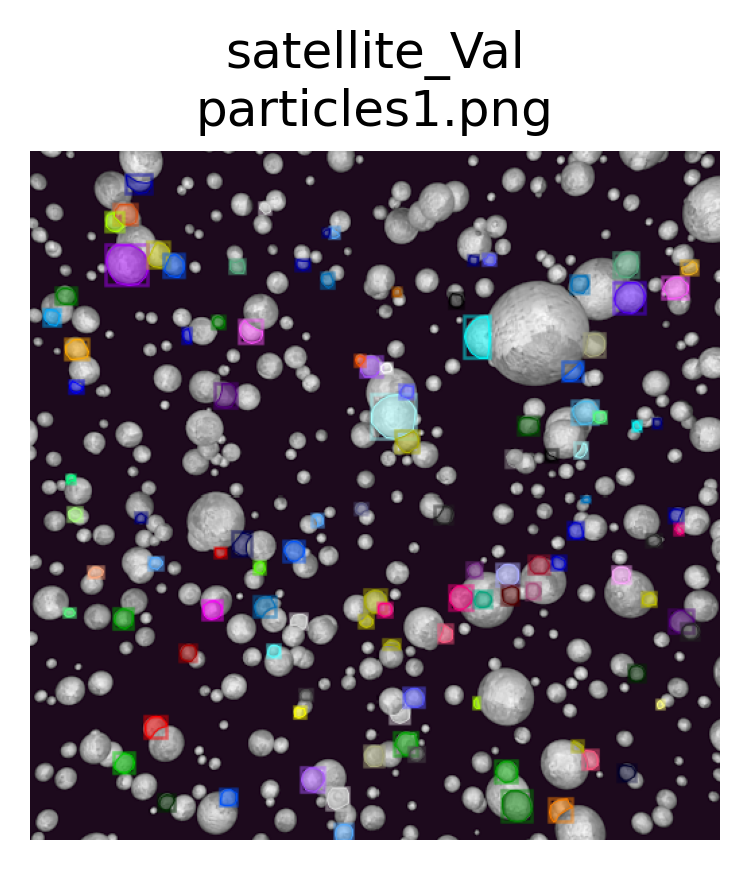

ddict info:
	path: ../../../../../../../ocean/projects/dmr200021p/sprice/synthetic_training/trainings/../images/a-lognormal-loc0.1-shape0.5/renders/particles1.png
	num_instances: 110


In [11]:
for i in DatasetCatalog.get(dataset_valid):
    visualize.display_ddicts(i, None, dataset_valid, suppress_labels=True)

## Model Configuration
This is where we specify the directory where the outputs are saved, various hyperparameters for the model, and more.

In [12]:
cfg = get_cfg() # initialize cfg object
cfg.merge_from_file(model_zoo.get_config_file('COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml'))  # load default parameters for Mask R-CNN
cfg.INPUT.MASK_FORMAT = 'polygon'  # masks generated in VGG image annotator are polygons
cfg.DATASETS.TRAIN = (dataset_train,)  # dataset used for training model
cfg.DATASETS.TEST = (dataset_train, dataset_valid)  # we will look at the predictions on both sets after training
cfg.SOLVER.IMS_PER_BATCH = 1 # number of images per batch (across all machines)
cfg.SOLVER.CHECKPOINT_PERIOD = 1000  # number of iterations after which to save model checkpoints
cfg.MODEL.DEVICE='cuda'  # 'cpu' to force model to run on cpu, 'cuda' if you have a compatible gpu
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1 # Since we are training separate models for particles and satellites there is only one class output
cfg.TEST.DETECTIONS_PER_IMAGE = 400 if EXPERIMENT_NAME == 'particle' else 250  # maximum number of instances that can be detected in an image (this is fixed in mask r-cnn)
cfg.SOLVER.MAX_ITER = 15000  # maximum number of iterations to run during training
                            # Increasing this may improve the training results, but will take longer to run (especially without a gpu!)

# model weights will be downloaded if they are not present
weights_path = Path('..','..','models','model_final_f10217.pkl')
if weights_path.is_file():
    print('Using locally stored weights: {}'.format(weights_path))
else:
    weights_path = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
    print('Weights not found, weights will be downloaded from source: {}'.format(weights_path))
cfg.MODEL.WEIGHTs = str(weights_path)
cfg.OUTPUT_DIR = str(Path(ocean_syn,'Models', 'Synthetic_training_a1.0'))
# make the output directory
os.makedirs(Path(cfg.OUTPUT_DIR), exist_ok=True)

Weights not found, weights will be downloaded from source: https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl


# Model Training
Once we have everything set up, training is very easy!

Note- this block will generate a huge wall of text.

In [13]:
trainer = DefaultTrainer(cfg)  # create trainer object from cfg
trainer.resume_or_load(resume=False)  # start training from iteration 0
trainer.train()  # train the model!

[07/26 16:16:20 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[07/26 16:16:20 d2.data.build]: Removed 0 images with no usable annotations. 1 images left.
[07/26 16:16:20 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
| satellite  | 148          |
|            |              |
[07/26 16:16:20 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[07/26 16:16:20 d2.data.build]: Using training sampler TrainingSampler
[07/26 16:16:20 d2.data.common]: Serializing 1 elements to byte tensors and concatenating them all ...
[07/26 16:16:20 d2.data.common]: Serialized dataset takes 0.04 MiB
WARNING [07/26 16:16:20 d2.solver.build]: SOLVER.STEPS contains values larger than SOLVER.MAX_ITER. These values will be ignored.


/jet/home/sprice/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py:474: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[07/26 16:16:20 d2.checkpoint.c2_model_loading]: Renaming Caffe2 weights ......
[07/26 16:16:20 d2.checkpoint.c2_model_loading]: Following weights matched with submodule backbone.bottom_up:
| Names in Model    | Names in Checkpoint      | Shapes                                          |
|:------------------|:-------------------------|:------------------------------------------------|
| res2.0.conv1.*    | res2_0_branch2a_{bn_*,w} | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| res2.0.conv2.*    | res2_0_branch2b_{bn_*,w} | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| res2.0.conv3.*    | res2_0_branch2c_{bn_*,w} | (256,) (256,) (256,) (256,) (256,64,1,1)        |
| res2.0.shortcut.* | res2_0_branch1_{bn_*,w}  | (256,) (256,) (256,) (256,) (256,64,1,1)        |
| res2.1.conv1.*    | res2_1_branch2a_{bn_*,w} | (64,) (64,) (64,) (64,) (64,256,1,1)            |
| res2.1.conv2.*    | res2_1_branch2b_{bn_*,w} | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| res2.1.conv3.*  

[07/26 16:16:51 d2.utils.events]:  eta: 0:31:53  iter: 219  total_loss: 1.325  loss_cls: 0.1852  loss_box_reg: 0.3649  loss_mask: 0.3256  loss_rpn_cls: 0.2106  loss_rpn_loc: 0.2543  time: 0.1299  data_time: 0.0141  lr: 0.0043956  max_mem: 1548M
[07/26 16:16:53 d2.utils.events]:  eta: 0:31:49  iter: 239  total_loss: 1.354  loss_cls: 0.1714  loss_box_reg: 0.3916  loss_mask: 0.3288  loss_rpn_cls: 0.2081  loss_rpn_loc: 0.2565  time: 0.1299  data_time: 0.0146  lr: 0.0047952  max_mem: 1548M
[07/26 16:16:56 d2.utils.events]:  eta: 0:31:45  iter: 259  total_loss: 1.329  loss_cls: 0.1601  loss_box_reg: 0.3693  loss_mask: 0.318  loss_rpn_cls: 0.1993  loss_rpn_loc: 0.2667  time: 0.1299  data_time: 0.0141  lr: 0.0051948  max_mem: 1548M
[07/26 16:16:59 d2.utils.events]:  eta: 0:31:40  iter: 279  total_loss: 1.298  loss_cls: 0.1614  loss_box_reg: 0.3598  loss_mask: 0.3019  loss_rpn_cls: 0.192  loss_rpn_loc: 0.2704  time: 0.1298  data_time: 0.0146  lr: 0.0055944  max_mem: 1548M
[07/26 16:17:01 d2.uti

[07/26 16:18:18 d2.utils.events]:  eta: 0:30:35  iter: 879  total_loss: 0.8086  loss_cls: 0.08748  loss_box_reg: 0.2264  loss_mask: 0.1413  loss_rpn_cls: 0.09661  loss_rpn_loc: 0.2355  time: 0.1307  data_time: 0.0141  lr: 0.017582  max_mem: 1548M
[07/26 16:18:21 d2.utils.events]:  eta: 0:30:33  iter: 899  total_loss: 0.8154  loss_cls: 0.09632  loss_box_reg: 0.234  loss_mask: 0.1377  loss_rpn_cls: 0.08993  loss_rpn_loc: 0.2367  time: 0.1308  data_time: 0.0146  lr: 0.017982  max_mem: 1548M
[07/26 16:18:24 d2.utils.events]:  eta: 0:30:31  iter: 919  total_loss: 0.7786  loss_cls: 0.1008  loss_box_reg: 0.2223  loss_mask: 0.1438  loss_rpn_cls: 0.06754  loss_rpn_loc: 0.2269  time: 0.1308  data_time: 0.0142  lr: 0.018382  max_mem: 1548M
[07/26 16:18:26 d2.utils.events]:  eta: 0:30:28  iter: 939  total_loss: 0.7509  loss_cls: 0.0959  loss_box_reg: 0.2228  loss_mask: 0.1288  loss_rpn_cls: 0.08686  loss_rpn_loc: 0.2195  time: 0.1308  data_time: 0.0149  lr: 0.018781  max_mem: 1548M
[07/26 16:18:29

[07/26 16:19:48 d2.utils.events]:  eta: 0:29:21  iter: 1539  total_loss: 0.5632  loss_cls: 0.0629  loss_box_reg: 0.1746  loss_mask: 0.09945  loss_rpn_cls: 0.03331  loss_rpn_loc: 0.1807  time: 0.1312  data_time: 0.0153  lr: 0.02  max_mem: 1548M
[07/26 16:19:50 d2.utils.events]:  eta: 0:29:19  iter: 1559  total_loss: 0.5579  loss_cls: 0.07287  loss_box_reg: 0.169  loss_mask: 0.09311  loss_rpn_cls: 0.05265  loss_rpn_loc: 0.1721  time: 0.1312  data_time: 0.0146  lr: 0.02  max_mem: 1548M
[07/26 16:19:53 d2.utils.events]:  eta: 0:29:17  iter: 1579  total_loss: 0.552  loss_cls: 0.06374  loss_box_reg: 0.1606  loss_mask: 0.09059  loss_rpn_cls: 0.05596  loss_rpn_loc: 0.1805  time: 0.1313  data_time: 0.0149  lr: 0.02  max_mem: 1548M
[07/26 16:19:56 d2.utils.events]:  eta: 0:29:14  iter: 1599  total_loss: 0.5669  loss_cls: 0.07854  loss_box_reg: 0.1698  loss_mask: 0.09863  loss_rpn_cls: 0.04731  loss_rpn_loc: 0.1734  time: 0.1313  data_time: 0.0148  lr: 0.02  max_mem: 1548M
[07/26 16:19:59 d2.util

[07/26 16:21:23 d2.utils.events]:  eta: 0:28:19  iter: 2199  total_loss: 0.4328  loss_cls: 0.04902  loss_box_reg: 0.1345  loss_mask: 0.07212  loss_rpn_cls: 0.02486  loss_rpn_loc: 0.1389  time: 0.1343  data_time: 0.0142  lr: 0.02  max_mem: 1548M
[07/26 16:21:25 d2.utils.events]:  eta: 0:28:16  iter: 2219  total_loss: 0.4426  loss_cls: 0.04868  loss_box_reg: 0.1313  loss_mask: 0.07339  loss_rpn_cls: 0.03361  loss_rpn_loc: 0.1532  time: 0.1343  data_time: 0.0140  lr: 0.02  max_mem: 1548M
[07/26 16:21:28 d2.utils.events]:  eta: 0:28:14  iter: 2239  total_loss: 0.444  loss_cls: 0.05153  loss_box_reg: 0.137  loss_mask: 0.07752  loss_rpn_cls: 0.03705  loss_rpn_loc: 0.1499  time: 0.1342  data_time: 0.0143  lr: 0.02  max_mem: 1548M
[07/26 16:21:31 d2.utils.events]:  eta: 0:28:12  iter: 2259  total_loss: 0.4376  loss_cls: 0.05409  loss_box_reg: 0.1299  loss_mask: 0.07343  loss_rpn_cls: 0.03246  loss_rpn_loc: 0.1398  time: 0.1342  data_time: 0.0143  lr: 0.02  max_mem: 1548M
[07/26 16:21:33 d2.uti

[07/26 16:22:56 d2.utils.events]:  eta: 0:26:59  iter: 2859  total_loss: 0.3728  loss_cls: 0.0368  loss_box_reg: 0.1184  loss_mask: 0.06106  loss_rpn_cls: 0.02652  loss_rpn_loc: 0.1264  time: 0.1357  data_time: 0.0146  lr: 0.02  max_mem: 1548M
[07/26 16:23:00 d2.utils.events]:  eta: 0:26:57  iter: 2879  total_loss: 0.3693  loss_cls: 0.043  loss_box_reg: 0.1161  loss_mask: 0.06104  loss_rpn_cls: 0.02478  loss_rpn_loc: 0.1245  time: 0.1359  data_time: 0.0175  lr: 0.02  max_mem: 1548M
[07/26 16:23:03 d2.utils.events]:  eta: 0:26:53  iter: 2899  total_loss: 0.3797  loss_cls: 0.03711  loss_box_reg: 0.1187  loss_mask: 0.0604  loss_rpn_cls: 0.02325  loss_rpn_loc: 0.1248  time: 0.1359  data_time: 0.0149  lr: 0.02  max_mem: 1548M
[07/26 16:23:05 d2.utils.events]:  eta: 0:26:48  iter: 2919  total_loss: 0.3882  loss_cls: 0.03938  loss_box_reg: 0.1145  loss_mask: 0.06231  loss_rpn_cls: 0.02771  loss_rpn_loc: 0.1381  time: 0.1359  data_time: 0.0144  lr: 0.02  max_mem: 1548M
[07/26 16:23:09 d2.utils

[07/26 16:24:30 d2.utils.events]:  eta: 0:25:35  iter: 3519  total_loss: 0.3247  loss_cls: 0.03404  loss_box_reg: 0.1054  loss_mask: 0.05319  loss_rpn_cls: 0.01251  loss_rpn_loc: 0.1172  time: 0.1364  data_time: 0.0145  lr: 0.02  max_mem: 1548M
[07/26 16:24:33 d2.utils.events]:  eta: 0:25:33  iter: 3539  total_loss: 0.3348  loss_cls: 0.03126  loss_box_reg: 0.1028  loss_mask: 0.05493  loss_rpn_cls: 0.02164  loss_rpn_loc: 0.1199  time: 0.1363  data_time: 0.0151  lr: 0.02  max_mem: 1548M
[07/26 16:24:36 d2.utils.events]:  eta: 0:25:29  iter: 3559  total_loss: 0.3439  loss_cls: 0.0338  loss_box_reg: 0.1034  loss_mask: 0.05226  loss_rpn_cls: 0.02245  loss_rpn_loc: 0.1246  time: 0.1363  data_time: 0.0142  lr: 0.02  max_mem: 1548M
[07/26 16:24:38 d2.utils.events]:  eta: 0:25:24  iter: 3579  total_loss: 0.3531  loss_cls: 0.03979  loss_box_reg: 0.1072  loss_mask: 0.0546  loss_rpn_cls: 0.01719  loss_rpn_loc: 0.126  time: 0.1363  data_time: 0.0138  lr: 0.02  max_mem: 1548M
[07/26 16:24:41 d2.util

[07/26 16:25:59 d2.utils.events]:  eta: 0:23:39  iter: 4179  total_loss: 0.3185  loss_cls: 0.03178  loss_box_reg: 0.1018  loss_mask: 0.05232  loss_rpn_cls: 0.02131  loss_rpn_loc: 0.1129  time: 0.1357  data_time: 0.0140  lr: 0.02  max_mem: 1548M
[07/26 16:26:02 d2.utils.events]:  eta: 0:23:36  iter: 4199  total_loss: 0.3137  loss_cls: 0.03285  loss_box_reg: 0.0967  loss_mask: 0.05146  loss_rpn_cls: 0.02362  loss_rpn_loc: 0.1183  time: 0.1357  data_time: 0.0143  lr: 0.02  max_mem: 1548M
[07/26 16:26:05 d2.utils.events]:  eta: 0:23:34  iter: 4219  total_loss: 0.322  loss_cls: 0.02919  loss_box_reg: 0.1024  loss_mask: 0.0514  loss_rpn_cls: 0.02079  loss_rpn_loc: 0.1123  time: 0.1356  data_time: 0.0149  lr: 0.02  max_mem: 1548M
[07/26 16:26:07 d2.utils.events]:  eta: 0:23:31  iter: 4239  total_loss: 0.2828  loss_cls: 0.02419  loss_box_reg: 0.08473  loss_mask: 0.04891  loss_rpn_cls: 0.01649  loss_rpn_loc: 0.1087  time: 0.1356  data_time: 0.0137  lr: 0.02  max_mem: 1548M
[07/26 16:26:10 d2.ut

[07/26 16:27:28 d2.utils.events]:  eta: 0:22:15  iter: 4839  total_loss: 0.3037  loss_cls: 0.02859  loss_box_reg: 0.0962  loss_mask: 0.04959  loss_rpn_cls: 0.01597  loss_rpn_loc: 0.1118  time: 0.1352  data_time: 0.0149  lr: 0.02  max_mem: 1548M
[07/26 16:27:30 d2.utils.events]:  eta: 0:22:12  iter: 4859  total_loss: 0.3003  loss_cls: 0.0309  loss_box_reg: 0.09157  loss_mask: 0.05525  loss_rpn_cls: 0.01704  loss_rpn_loc: 0.1086  time: 0.1352  data_time: 0.0142  lr: 0.02  max_mem: 1548M
[07/26 16:27:33 d2.utils.events]:  eta: 0:22:10  iter: 4879  total_loss: 0.2736  loss_cls: 0.02306  loss_box_reg: 0.08088  loss_mask: 0.04726  loss_rpn_cls: 0.01763  loss_rpn_loc: 0.09905  time: 0.1352  data_time: 0.0145  lr: 0.02  max_mem: 1548M
[07/26 16:27:36 d2.utils.events]:  eta: 0:22:07  iter: 4899  total_loss: 0.2963  loss_cls: 0.0243  loss_box_reg: 0.08463  loss_mask: 0.04547  loss_rpn_cls: 0.01838  loss_rpn_loc: 0.1067  time: 0.1351  data_time: 0.0143  lr: 0.02  max_mem: 1548M
[07/26 16:27:39 d2

[07/26 16:28:57 d2.utils.events]:  eta: 0:20:47  iter: 5499  total_loss: 0.2694  loss_cls: 0.02629  loss_box_reg: 0.08433  loss_mask: 0.04266  loss_rpn_cls: 0.0121  loss_rpn_loc: 0.09696  time: 0.1349  data_time: 0.0139  lr: 0.02  max_mem: 1548M
[07/26 16:29:00 d2.utils.events]:  eta: 0:20:45  iter: 5519  total_loss: 0.2777  loss_cls: 0.0286  loss_box_reg: 0.08508  loss_mask: 0.04476  loss_rpn_cls: 0.01135  loss_rpn_loc: 0.09657  time: 0.1349  data_time: 0.0145  lr: 0.02  max_mem: 1548M
[07/26 16:29:02 d2.utils.events]:  eta: 0:20:41  iter: 5539  total_loss: 0.2923  loss_cls: 0.02991  loss_box_reg: 0.08836  loss_mask: 0.04742  loss_rpn_cls: 0.01912  loss_rpn_loc: 0.1098  time: 0.1348  data_time: 0.0139  lr: 0.02  max_mem: 1548M
[07/26 16:29:05 d2.utils.events]:  eta: 0:20:38  iter: 5559  total_loss: 0.2948  loss_cls: 0.02486  loss_box_reg: 0.08736  loss_mask: 0.05203  loss_rpn_cls: 0.01534  loss_rpn_loc: 0.1088  time: 0.1348  data_time: 0.0138  lr: 0.02  max_mem: 1548M
[07/26 16:29:07 

[07/26 16:30:25 d2.utils.events]:  eta: 0:19:17  iter: 6159  total_loss: 0.2743  loss_cls: 0.02792  loss_box_reg: 0.08631  loss_mask: 0.04128  loss_rpn_cls: 0.01066  loss_rpn_loc: 0.0975  time: 0.1345  data_time: 0.0141  lr: 0.02  max_mem: 1548M
[07/26 16:30:28 d2.utils.events]:  eta: 0:19:14  iter: 6179  total_loss: 0.2714  loss_cls: 0.02564  loss_box_reg: 0.08132  loss_mask: 0.04115  loss_rpn_cls: 0.01479  loss_rpn_loc: 0.09899  time: 0.1345  data_time: 0.0143  lr: 0.02  max_mem: 1548M
[07/26 16:30:31 d2.utils.events]:  eta: 0:19:12  iter: 6199  total_loss: 0.2576  loss_cls: 0.02366  loss_box_reg: 0.08561  loss_mask: 0.04328  loss_rpn_cls: 0.01012  loss_rpn_loc: 0.09296  time: 0.1345  data_time: 0.0146  lr: 0.02  max_mem: 1548M
[07/26 16:30:33 d2.utils.events]:  eta: 0:19:11  iter: 6219  total_loss: 0.2502  loss_cls: 0.02564  loss_box_reg: 0.08125  loss_mask: 0.04224  loss_rpn_cls: 0.01305  loss_rpn_loc: 0.0909  time: 0.1345  data_time: 0.0145  lr: 0.02  max_mem: 1548M
[07/26 16:30:3

[07/26 16:31:59 d2.utils.events]:  eta: 0:18:27  iter: 6819  total_loss: 0.2461  loss_cls: 0.02128  loss_box_reg: 0.08006  loss_mask: 0.03929  loss_rpn_cls: 0.01118  loss_rpn_loc: 0.09346  time: 0.1351  data_time: 0.0156  lr: 0.02  max_mem: 1548M
[07/26 16:32:01 d2.utils.events]:  eta: 0:18:24  iter: 6839  total_loss: 0.2507  loss_cls: 0.02136  loss_box_reg: 0.07437  loss_mask: 0.04019  loss_rpn_cls: 0.01483  loss_rpn_loc: 0.09778  time: 0.1351  data_time: 0.0142  lr: 0.02  max_mem: 1548M
[07/26 16:32:04 d2.utils.events]:  eta: 0:18:22  iter: 6859  total_loss: 0.2597  loss_cls: 0.02166  loss_box_reg: 0.08015  loss_mask: 0.04482  loss_rpn_cls: 0.01265  loss_rpn_loc: 0.0948  time: 0.1351  data_time: 0.0145  lr: 0.02  max_mem: 1548M
[07/26 16:32:07 d2.utils.events]:  eta: 0:18:20  iter: 6879  total_loss: 0.2349  loss_cls: 0.01746  loss_box_reg: 0.07454  loss_mask: 0.04028  loss_rpn_cls: 0.01405  loss_rpn_loc: 0.08707  time: 0.1351  data_time: 0.0143  lr: 0.02  max_mem: 1548M
[07/26 16:32:

[07/26 16:33:26 d2.utils.events]:  eta: 0:16:57  iter: 7459  total_loss: 0.2095  loss_cls: 0.01719  loss_box_reg: 0.06367  loss_mask: 0.03562  loss_rpn_cls: 0.007375  loss_rpn_loc: 0.08459  time: 0.1349  data_time: 0.0144  lr: 0.02  max_mem: 1548M
[07/26 16:33:28 d2.utils.events]:  eta: 0:16:53  iter: 7479  total_loss: 0.2275  loss_cls: 0.01812  loss_box_reg: 0.07109  loss_mask: 0.03618  loss_rpn_cls: 0.01153  loss_rpn_loc: 0.09008  time: 0.1349  data_time: 0.0144  lr: 0.02  max_mem: 1548M
[07/26 16:33:31 d2.utils.events]:  eta: 0:16:49  iter: 7499  total_loss: 0.2415  loss_cls: 0.01891  loss_box_reg: 0.07461  loss_mask: 0.0381  loss_rpn_cls: 0.01209  loss_rpn_loc: 0.09096  time: 0.1349  data_time: 0.0142  lr: 0.02  max_mem: 1548M
[07/26 16:33:34 d2.utils.events]:  eta: 0:16:45  iter: 7519  total_loss: 0.26  loss_cls: 0.02251  loss_box_reg: 0.07514  loss_mask: 0.03948  loss_rpn_cls: 0.01827  loss_rpn_loc: 0.1013  time: 0.1349  data_time: 0.0150  lr: 0.02  max_mem: 1548M
[07/26 16:33:36

[07/26 16:34:57 d2.utils.events]:  eta: 0:15:16  iter: 8119  total_loss: 0.2281  loss_cls: 0.01713  loss_box_reg: 0.0814  loss_mask: 0.03681  loss_rpn_cls: 0.008222  loss_rpn_loc: 0.08155  time: 0.1349  data_time: 0.0147  lr: 0.02  max_mem: 1548M
[07/26 16:35:00 d2.utils.events]:  eta: 0:15:14  iter: 8139  total_loss: 0.2221  loss_cls: 0.0169  loss_box_reg: 0.07676  loss_mask: 0.03817  loss_rpn_cls: 0.01214  loss_rpn_loc: 0.08071  time: 0.1350  data_time: 0.0154  lr: 0.02  max_mem: 1548M
[07/26 16:35:03 d2.utils.events]:  eta: 0:15:12  iter: 8159  total_loss: 0.2471  loss_cls: 0.01668  loss_box_reg: 0.07876  loss_mask: 0.04237  loss_rpn_cls: 0.01352  loss_rpn_loc: 0.08718  time: 0.1350  data_time: 0.0142  lr: 0.02  max_mem: 1548M
[07/26 16:35:05 d2.utils.events]:  eta: 0:15:10  iter: 8179  total_loss: 0.2364  loss_cls: 0.01809  loss_box_reg: 0.07667  loss_mask: 0.04062  loss_rpn_cls: 0.008752  loss_rpn_loc: 0.09125  time: 0.1350  data_time: 0.0145  lr: 0.02  max_mem: 1548M
[07/26 16:35

[07/26 16:36:28 d2.utils.events]:  eta: 0:13:58  iter: 8779  total_loss: 0.2109  loss_cls: 0.01712  loss_box_reg: 0.06454  loss_mask: 0.03464  loss_rpn_cls: 0.005457  loss_rpn_loc: 0.08338  time: 0.1350  data_time: 0.0146  lr: 0.02  max_mem: 1548M
[07/26 16:36:31 d2.utils.events]:  eta: 0:13:55  iter: 8799  total_loss: 0.2106  loss_cls: 0.01658  loss_box_reg: 0.06754  loss_mask: 0.03641  loss_rpn_cls: 0.007576  loss_rpn_loc: 0.08598  time: 0.1350  data_time: 0.0148  lr: 0.02  max_mem: 1548M
[07/26 16:36:34 d2.utils.events]:  eta: 0:13:52  iter: 8819  total_loss: 0.203  loss_cls: 0.01584  loss_box_reg: 0.06486  loss_mask: 0.03472  loss_rpn_cls: 0.007518  loss_rpn_loc: 0.07863  time: 0.1350  data_time: 0.0147  lr: 0.02  max_mem: 1548M
[07/26 16:36:37 d2.utils.events]:  eta: 0:13:50  iter: 8839  total_loss: 0.2094  loss_cls: 0.01574  loss_box_reg: 0.06521  loss_mask: 0.03454  loss_rpn_cls: 0.01088  loss_rpn_loc: 0.0819  time: 0.1350  data_time: 0.0146  lr: 0.02  max_mem: 1548M
[07/26 16:3

[07/26 16:38:00 d2.utils.events]:  eta: 0:12:32  iter: 9439  total_loss: 0.2033  loss_cls: 0.01515  loss_box_reg: 0.06698  loss_mask: 0.03144  loss_rpn_cls: 0.008391  loss_rpn_loc: 0.07997  time: 0.1351  data_time: 0.0149  lr: 0.02  max_mem: 1548M
[07/26 16:38:03 d2.utils.events]:  eta: 0:12:29  iter: 9459  total_loss: 0.2074  loss_cls: 0.01529  loss_box_reg: 0.06456  loss_mask: 0.03136  loss_rpn_cls: 0.01089  loss_rpn_loc: 0.08074  time: 0.1351  data_time: 0.0146  lr: 0.02  max_mem: 1548M
[07/26 16:38:06 d2.utils.events]:  eta: 0:12:26  iter: 9479  total_loss: 0.1936  loss_cls: 0.01463  loss_box_reg: 0.05894  loss_mask: 0.03217  loss_rpn_cls: 0.004654  loss_rpn_loc: 0.07725  time: 0.1351  data_time: 0.0153  lr: 0.02  max_mem: 1548M
[07/26 16:38:08 d2.utils.events]:  eta: 0:12:24  iter: 9499  total_loss: 0.2047  loss_cls: 0.01688  loss_box_reg: 0.06061  loss_mask: 0.03626  loss_rpn_cls: 0.005835  loss_rpn_loc: 0.08161  time: 0.1351  data_time: 0.0148  lr: 0.02  max_mem: 1548M
[07/26 16

[07/26 16:39:30 d2.utils.events]:  eta: 0:11:07  iter: 10079  total_loss: 0.1973  loss_cls: 0.01261  loss_box_reg: 0.06271  loss_mask: 0.03462  loss_rpn_cls: 0.007774  loss_rpn_loc: 0.07767  time: 0.1352  data_time: 0.0150  lr: 0.02  max_mem: 1548M
[07/26 16:39:33 d2.utils.events]:  eta: 0:11:04  iter: 10099  total_loss: 0.2054  loss_cls: 0.01683  loss_box_reg: 0.06544  loss_mask: 0.03412  loss_rpn_cls: 0.006326  loss_rpn_loc: 0.0748  time: 0.1352  data_time: 0.0147  lr: 0.02  max_mem: 1548M
[07/26 16:39:36 d2.utils.events]:  eta: 0:11:01  iter: 10119  total_loss: 0.2066  loss_cls: 0.01571  loss_box_reg: 0.06721  loss_mask: 0.0335  loss_rpn_cls: 0.007512  loss_rpn_loc: 0.0822  time: 0.1352  data_time: 0.0148  lr: 0.02  max_mem: 1548M
[07/26 16:39:38 d2.utils.events]:  eta: 0:10:59  iter: 10139  total_loss: 0.1901  loss_cls: 0.01369  loss_box_reg: 0.05851  loss_mask: 0.03256  loss_rpn_cls: 0.006567  loss_rpn_loc: 0.07899  time: 0.1352  data_time: 0.0149  lr: 0.02  max_mem: 1548M
[07/26 

[07/26 16:41:03 d2.utils.events]:  eta: 0:09:46  iter: 10719  total_loss: 0.2  loss_cls: 0.0125  loss_box_reg: 0.06396  loss_mask: 0.03425  loss_rpn_cls: 0.006194  loss_rpn_loc: 0.08262  time: 0.1357  data_time: 0.0142  lr: 0.02  max_mem: 1548M
[07/26 16:41:06 d2.utils.events]:  eta: 0:09:43  iter: 10739  total_loss: 0.2193  loss_cls: 0.01663  loss_box_reg: 0.07022  loss_mask: 0.04102  loss_rpn_cls: 0.006707  loss_rpn_loc: 0.08056  time: 0.1357  data_time: 0.0143  lr: 0.02  max_mem: 1548M
[07/26 16:41:09 d2.utils.events]:  eta: 0:09:41  iter: 10759  total_loss: 0.1892  loss_cls: 0.01217  loss_box_reg: 0.05764  loss_mask: 0.03285  loss_rpn_cls: 0.006868  loss_rpn_loc: 0.07476  time: 0.1357  data_time: 0.0147  lr: 0.02  max_mem: 1548M
[07/26 16:41:12 d2.utils.events]:  eta: 0:09:38  iter: 10779  total_loss: 0.1852  loss_cls: 0.01012  loss_box_reg: 0.0569  loss_mask: 0.03234  loss_rpn_cls: 0.007074  loss_rpn_loc: 0.07509  time: 0.1357  data_time: 0.0161  lr: 0.02  max_mem: 1548M
[07/26 16

[07/26 16:42:33 d2.utils.events]:  eta: 0:08:18  iter: 11359  total_loss: 0.1741  loss_cls: 0.0124  loss_box_reg: 0.05554  loss_mask: 0.03141  loss_rpn_cls: 0.004394  loss_rpn_loc: 0.0682  time: 0.1357  data_time: 0.0148  lr: 0.02  max_mem: 1548M
[07/26 16:42:36 d2.utils.events]:  eta: 0:08:15  iter: 11379  total_loss: 0.1765  loss_cls: 0.01218  loss_box_reg: 0.0542  loss_mask: 0.02973  loss_rpn_cls: 0.004731  loss_rpn_loc: 0.0716  time: 0.1357  data_time: 0.0148  lr: 0.02  max_mem: 1548M
[07/26 16:42:39 d2.utils.events]:  eta: 0:08:12  iter: 11399  total_loss: 0.1795  loss_cls: 0.009604  loss_box_reg: 0.05508  loss_mask: 0.03147  loss_rpn_cls: 0.006803  loss_rpn_loc: 0.07275  time: 0.1357  data_time: 0.0147  lr: 0.02  max_mem: 1548M
[07/26 16:42:42 d2.utils.events]:  eta: 0:08:09  iter: 11419  total_loss: 0.1789  loss_cls: 0.00995  loss_box_reg: 0.05147  loss_mask: 0.02894  loss_rpn_cls: 0.007289  loss_rpn_loc: 0.07413  time: 0.1357  data_time: 0.0145  lr: 0.02  max_mem: 1548M
[07/26 

[07/26 16:44:07 d2.utils.events]:  eta: 0:06:49  iter: 11999  total_loss: 0.2019  loss_cls: 0.01186  loss_box_reg: 0.06789  loss_mask: 0.03279  loss_rpn_cls: 0.005548  loss_rpn_loc: 0.07355  time: 0.1362  data_time: 0.0147  lr: 0.02  max_mem: 1548M
[07/26 16:44:10 d2.utils.events]:  eta: 0:06:46  iter: 12019  total_loss: 0.186  loss_cls: 0.01104  loss_box_reg: 0.05689  loss_mask: 0.03273  loss_rpn_cls: 0.005967  loss_rpn_loc: 0.07603  time: 0.1362  data_time: 0.0146  lr: 0.02  max_mem: 1548M
[07/26 16:44:13 d2.utils.events]:  eta: 0:06:43  iter: 12039  total_loss: 0.1814  loss_cls: 0.01023  loss_box_reg: 0.05338  loss_mask: 0.03158  loss_rpn_cls: 0.005961  loss_rpn_loc: 0.07711  time: 0.1362  data_time: 0.0147  lr: 0.02  max_mem: 1548M
[07/26 16:44:16 d2.utils.events]:  eta: 0:06:40  iter: 12059  total_loss: 0.188  loss_cls: 0.01107  loss_box_reg: 0.0608  loss_mask: 0.03288  loss_rpn_cls: 0.005396  loss_rpn_loc: 0.07745  time: 0.1362  data_time: 0.0144  lr: 0.02  max_mem: 1548M
[07/26 

[07/26 16:45:36 d2.utils.events]:  eta: 0:05:21  iter: 12639  total_loss: 0.1976  loss_cls: 0.01079  loss_box_reg: 0.05859  loss_mask: 0.03387  loss_rpn_cls: 0.007207  loss_rpn_loc: 0.0767  time: 0.1362  data_time: 0.0139  lr: 0.02  max_mem: 1548M
[07/26 16:45:39 d2.utils.events]:  eta: 0:05:18  iter: 12659  total_loss: 0.1785  loss_cls: 0.009715  loss_box_reg: 0.05472  loss_mask: 0.03315  loss_rpn_cls: 0.007513  loss_rpn_loc: 0.06973  time: 0.1362  data_time: 0.0151  lr: 0.02  max_mem: 1548M
[07/26 16:45:42 d2.utils.events]:  eta: 0:05:15  iter: 12679  total_loss: 0.168  loss_cls: 0.008964  loss_box_reg: 0.05234  loss_mask: 0.02939  loss_rpn_cls: 0.005183  loss_rpn_loc: 0.06866  time: 0.1362  data_time: 0.0142  lr: 0.02  max_mem: 1548M
[07/26 16:45:45 d2.utils.events]:  eta: 0:05:12  iter: 12699  total_loss: 0.1722  loss_cls: 0.01202  loss_box_reg: 0.05668  loss_mask: 0.03129  loss_rpn_cls: 0.004582  loss_rpn_loc: 0.06911  time: 0.1362  data_time: 0.0117  lr: 0.02  max_mem: 1548M
[07/

[07/26 16:47:06 d2.utils.events]:  eta: 0:03:52  iter: 13279  total_loss: 0.1753  loss_cls: 0.01073  loss_box_reg: 0.05663  loss_mask: 0.03021  loss_rpn_cls: 0.004584  loss_rpn_loc: 0.07153  time: 0.1362  data_time: 0.0145  lr: 0.02  max_mem: 1548M
[07/26 16:47:09 d2.utils.events]:  eta: 0:03:49  iter: 13299  total_loss: 0.1807  loss_cls: 0.009282  loss_box_reg: 0.05151  loss_mask: 0.03144  loss_rpn_cls: 0.007446  loss_rpn_loc: 0.07355  time: 0.1362  data_time: 0.0145  lr: 0.02  max_mem: 1548M
[07/26 16:47:12 d2.utils.events]:  eta: 0:03:46  iter: 13319  total_loss: 0.1835  loss_cls: 0.0124  loss_box_reg: 0.05491  loss_mask: 0.03133  loss_rpn_cls: 0.007718  loss_rpn_loc: 0.0755  time: 0.1362  data_time: 0.0148  lr: 0.02  max_mem: 1548M
[07/26 16:47:14 d2.utils.events]:  eta: 0:03:44  iter: 13339  total_loss: 0.1777  loss_cls: 0.01287  loss_box_reg: 0.05465  loss_mask: 0.03127  loss_rpn_cls: 0.00566  loss_rpn_loc: 0.07138  time: 0.1362  data_time: 0.0144  lr: 0.02  max_mem: 1548M
[07/26

[07/26 16:48:33 d2.utils.events]:  eta: 0:02:24  iter: 13919  total_loss: 0.1754  loss_cls: 0.009946  loss_box_reg: 0.05626  loss_mask: 0.0328  loss_rpn_cls: 0.005749  loss_rpn_loc: 0.06468  time: 0.1361  data_time: 0.0139  lr: 0.02  max_mem: 1548M
[07/26 16:48:36 d2.utils.events]:  eta: 0:02:21  iter: 13939  total_loss: 0.176  loss_cls: 0.01005  loss_box_reg: 0.05863  loss_mask: 0.03235  loss_rpn_cls: 0.00447  loss_rpn_loc: 0.07229  time: 0.1361  data_time: 0.0146  lr: 0.02  max_mem: 1548M
[07/26 16:48:38 d2.utils.events]:  eta: 0:02:18  iter: 13959  total_loss: 0.1873  loss_cls: 0.01126  loss_box_reg: 0.06892  loss_mask: 0.03491  loss_rpn_cls: 0.004826  loss_rpn_loc: 0.0726  time: 0.1361  data_time: 0.0142  lr: 0.02  max_mem: 1548M
[07/26 16:48:41 d2.utils.events]:  eta: 0:02:16  iter: 13979  total_loss: 0.1779  loss_cls: 0.0101  loss_box_reg: 0.06021  loss_mask: 0.03206  loss_rpn_cls: 0.00531  loss_rpn_loc: 0.06817  time: 0.1361  data_time: 0.0136  lr: 0.02  max_mem: 1548M
[07/26 16

[07/26 16:50:00 d2.utils.events]:  eta: 0:00:58  iter: 14559  total_loss: 0.1773  loss_cls: 0.01292  loss_box_reg: 0.05022  loss_mask: 0.02818  loss_rpn_cls: 0.005645  loss_rpn_loc: 0.07694  time: 0.1359  data_time: 0.0145  lr: 0.02  max_mem: 1548M
[07/26 16:50:03 d2.utils.events]:  eta: 0:00:55  iter: 14579  total_loss: 0.1742  loss_cls: 0.01032  loss_box_reg: 0.05486  loss_mask: 0.02887  loss_rpn_cls: 0.004089  loss_rpn_loc: 0.07237  time: 0.1359  data_time: 0.0149  lr: 0.02  max_mem: 1548M
[07/26 16:50:06 d2.utils.events]:  eta: 0:00:52  iter: 14599  total_loss: 0.1708  loss_cls: 0.01172  loss_box_reg: 0.05507  loss_mask: 0.03269  loss_rpn_cls: 0.003883  loss_rpn_loc: 0.06361  time: 0.1359  data_time: 0.0138  lr: 0.02  max_mem: 1548M
[07/26 16:50:08 d2.utils.events]:  eta: 0:00:50  iter: 14619  total_loss: 0.1719  loss_cls: 0.00997  loss_box_reg: 0.05597  loss_mask: 0.03204  loss_rpn_cls: 0.004845  loss_rpn_loc: 0.06337  time: 0.1359  data_time: 0.0137  lr: 0.02  max_mem: 1548M
[07/

# Visualizing model predictions
We will view the model predictions on the training and validation set.

In [16]:
model_checkpoints = sorted(Path(cfg.OUTPUT_DIR).glob('*.pth'))  # paths to weights saved druing training
#cfg.DATASETS.TEST = (dataset_train, dataset_valid)  # predictor requires this field to not be empty
cfg.MODEL.WEIGHTS = str(model_checkpoints[-1])  # use the last model checkpoint saved during training. If you want to see the performance of other checkpoints you can select a different index from model_checkpoints.
predictor = DefaultPredictor(cfg)  # create predictor object

Dataset: satellite_Train
	File: ../../../../../../../ocean/projects/dmr200021p/sprice/synthetic_training/trainings/../images/a-lognormal-loc0.1-shape0.5/renders/particles100.png


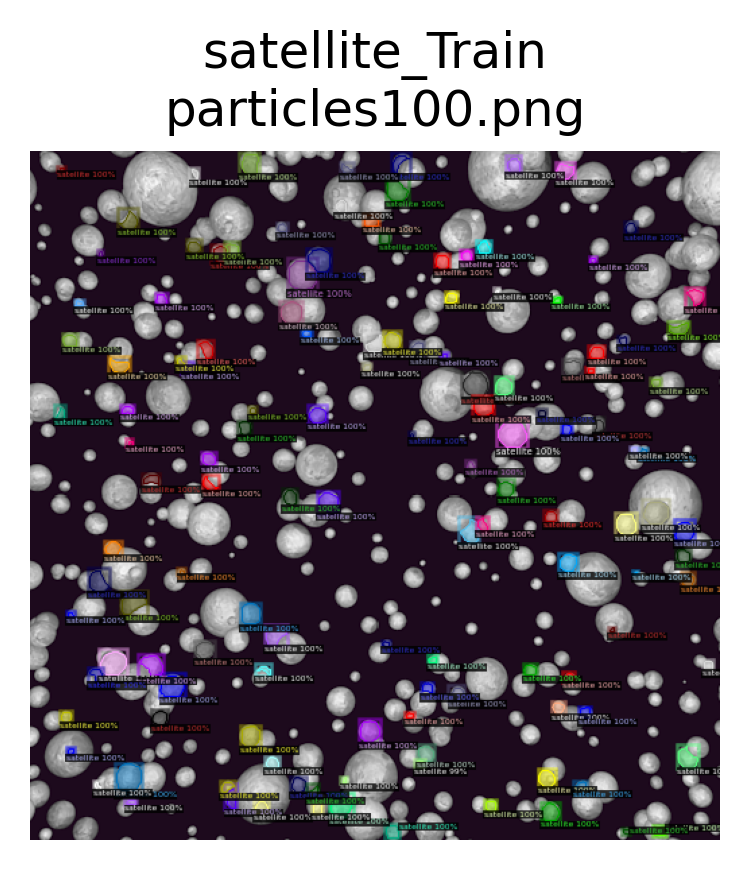

ddict info:
	path: ../../../../../../../ocean/projects/dmr200021p/sprice/synthetic_training/trainings/../images/a-lognormal-loc0.1-shape0.5/renders/particles100.png
	num_instances: 132
Dataset: satellite_Val
	File: ../../../../../../../ocean/projects/dmr200021p/sprice/synthetic_training/trainings/../images/a-lognormal-loc0.1-shape0.5/renders/particles11.png


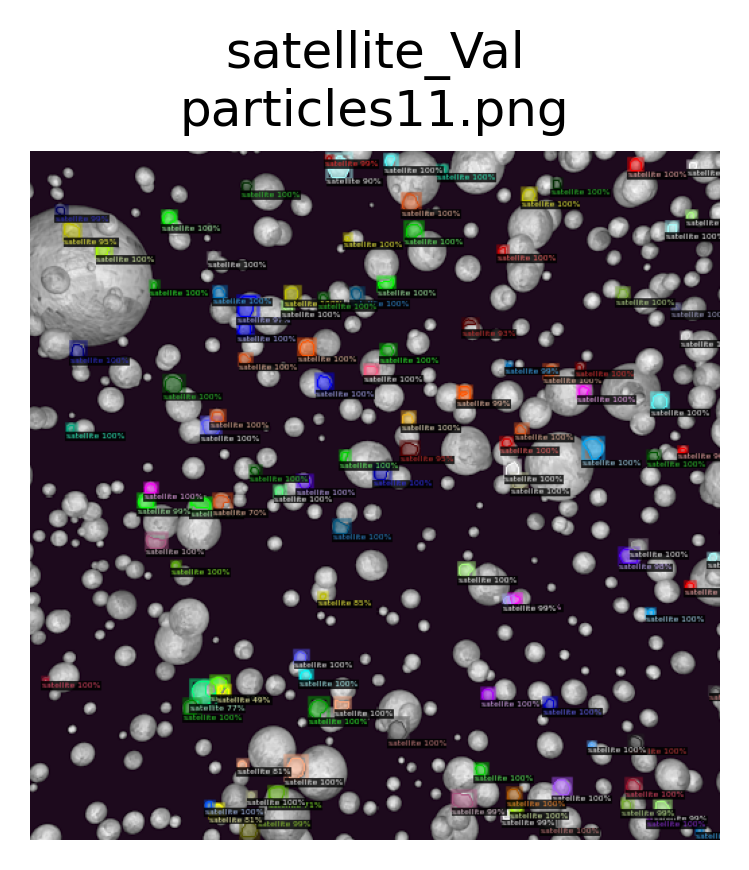

ddict info:
	path: ../../../../../../../ocean/projects/dmr200021p/sprice/synthetic_training/trainings/../images/a-lognormal-loc0.1-shape0.5/renders/particles11.png
	num_instances: 113
	File: ../../../../../../../ocean/projects/dmr200021p/sprice/synthetic_training/trainings/../images/a-lognormal-loc0.1-shape0.5/renders/particles10.png


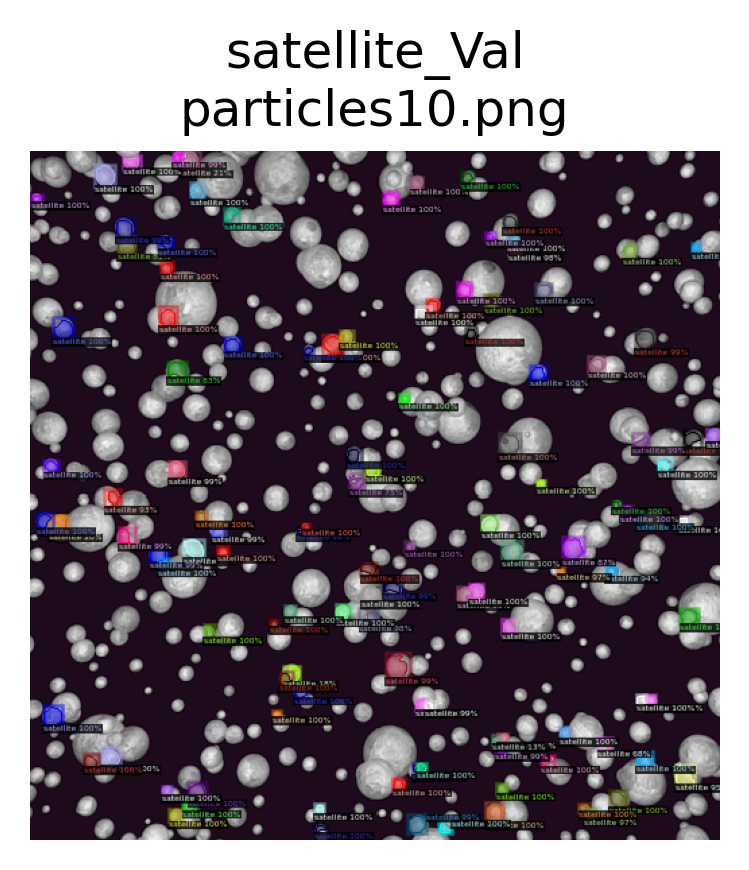

ddict info:
	path: ../../../../../../../ocean/projects/dmr200021p/sprice/synthetic_training/trainings/../images/a-lognormal-loc0.1-shape0.5/renders/particles10.png
	num_instances: 118
	File: ../../../../../../../ocean/projects/dmr200021p/sprice/synthetic_training/trainings/../images/a-lognormal-loc0.1-shape0.5/renders/particles1.png


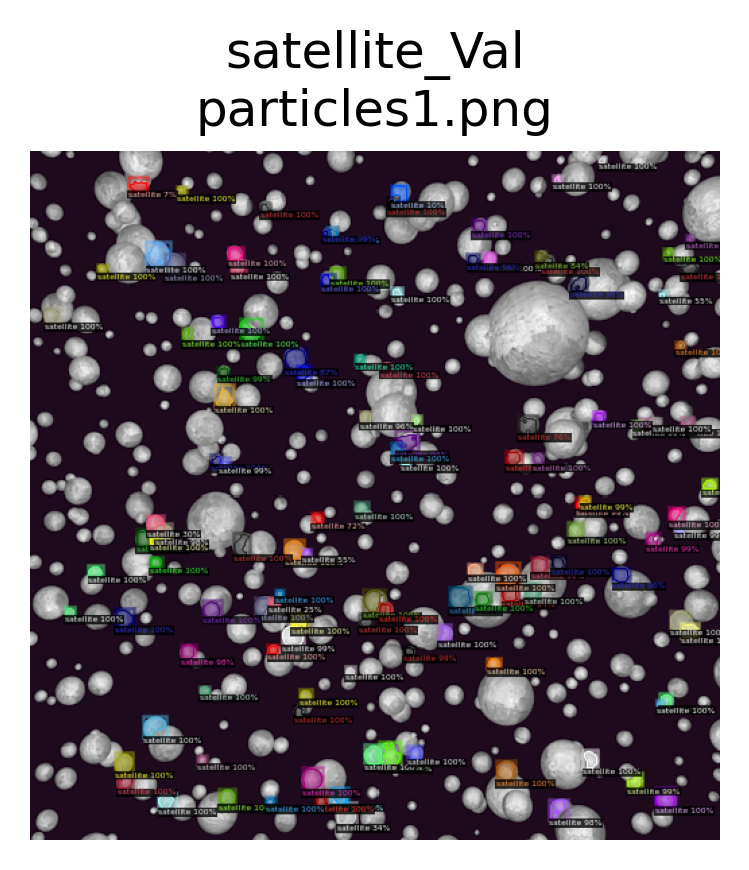

ddict info:
	path: ../../../../../../../ocean/projects/dmr200021p/sprice/synthetic_training/trainings/../images/a-lognormal-loc0.1-shape0.5/renders/particles1.png
	num_instances: 123


In [17]:
results = []
for ds in cfg.DATASETS.TEST:
    print(f'Dataset: {ds}')
    for dd in DatasetCatalog.get(ds):
        print(f'\tFile: {dd["file_name"]}')
        img = cv2.imread(dd['file_name'])  # load image
        outs = predictor(img)  # run inference on image
        
        # format results for visualization and store for later
        results.append(data_utils.format_outputs(dd['file_name'], ds, outs))

        # visualize results
        visualize.display_ddicts(outs, None, ds, gt=False, img_path=dd['file_name'])

# save to disk
#with open(Path('Stage_results',f'{EXPERIMENT_NAME}-base_stage.pickle'), 'wb') as f:
#    pickle.dump(results, f)

## Generating predictions on new images is simple.
We will load a new image (not included in either dataset) and generate predictions.
Note that we do not have labels for this image and do not need to register it to a dataset.

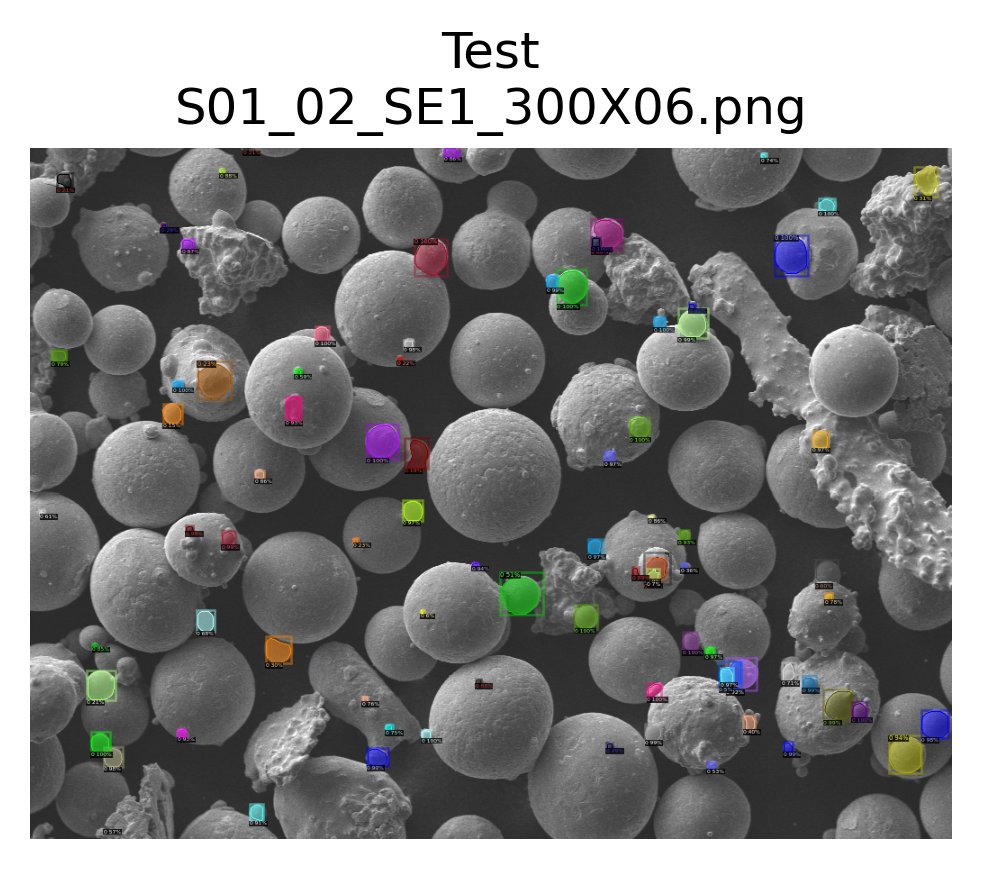

ddict info:
	path: ../Auto_annotate_images/S01_02_SE1_300X06.png
	num_instances: 84


In [11]:
img_path = Path('..', 'Auto_annotate_images','S01_02_SE1_300X06.png')
img = cv2.imread(str(img_path))
outs = predictor(img)
data_utils.format_outputs(img_path, dataset='test', pred=outs)
visualize.display_ddicts(ddict=outs,  # predictions to display
                                 outpath=None, dataset='Test',  # don't save figure
                                 gt=False,  # specifies format as model predictions
                                img_path=img_path)  # path to image


We will now generate predictions on all of the images in the training and validation sets, and save the results for later.

In [ ]:
files = os.listdir('Auto_annotate_images')
img_names = []
for f in files:
    if f.split('.')[0] != '250x' and f.split('.')[0] != '500x':
        img_names.append(f.split('.')[0])
        
results = []
for f in img_names:
    print("Annotating: " + f)
    img_path = Path('Auto_annotate_images', f +'.png')
    img = cv2.imread(str(img_path))
    outs = predictor(img)
    data_utils.format_outputs(img_path, dataset='test', pred=outs)
    visualize.display_ddicts(ddict=outs,  # predictions to display
                                 outpath=None, dataset='Test',  # don't save fi$
                                 gt=False,  # specifies format as model predict$
                                 img_path=img_path, # path to image
                                 suppress_labels=True, #hides class images
                                 summary=True)  #hides the end print statement

# save to disk
with open(Path('Stage_results',f'{EXPERIMENT_NAME}-base_stage.pickle'), 'wb') as f:
    pickle.dump(results, f)